In [21]:
import os
import numpy as np
import music21 as m21

In [14]:
DATASET_PATH = '../data/music_midi_dataset/'

In [9]:
def load_files(dataset_path):
    songs = []
    for path, subdirs, files in os.walk(dataset_path):
        for file in files:
            if file[-4:] == "midi" or file[-3:] == "mid":
                song = m21.converter.parse(os.path.join(path, file))
                songs.append(song)
    return songs

In [4]:
def read_midi(file):
    print("Loading Music File:",file)    
    notes=[]
    notes_to_parse = file.recurse()
    
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))  
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))
    
    return np.array(notes)

In [17]:
files=[i for i in os.listdir(DATASET_PATH+'test/') if i.endswith(".midi")]

In [19]:
print(len(files))

12


In [28]:
#defining function to read MIDI files
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = m21.converter.parse(file)
  
    #grouping based on different instruments
    s2 = m21.instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, m21.note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, m21.chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [30]:
notes_array = [read_midi(DATASET_PATH+'test/'+i) for i in files]

Loading Music File: ../data/music_midi_dataset/test/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi
Loading Music File: ../data/music_midi_dataset/test/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi
Loading Music File: ../data/music_midi_dataset/test/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--2.midi
Loading Music File: ../data/music_midi_dataset/test/MIDI-Unprocessed_Chamber4_MID--AUDIO_11_R3_2018_wav--1.midi
Loading Music File: ../data/music_midi_dataset/test/MIDI-Unprocessed_Chamber5_MID--AUDIO_18_R3_2018_wav--1.midi
Loading Music File: ../data/music_midi_dataset/test/MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R3_2018_wav--1.midi
Loading Music File: ../data/music_midi_dataset/test/MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R3_2018_wav--2.midi
Loading Music File: ../data/music_midi_dataset/test/MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--1.midi
Loading Music File: ../data/music_midi_dataset/test/MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_

In [32]:
print(len(notes_array))

12


In [33]:
notes_ = [element for note_ in notes_array for element in note_]
unique_notes = list(set(notes_))
print(len(unique_notes))

958


(array([824.,  45.,  34.,  20.,  13.,   7.,   3.,   5.,   5.,   2.]),
 array([1.0000e+00, 1.2540e+02, 2.4980e+02, 3.7420e+02, 4.9860e+02,
        6.2300e+02, 7.4740e+02, 8.7180e+02, 9.9620e+02, 1.1206e+03,
        1.2450e+03]),
 <BarContainer object of 10 artists>)

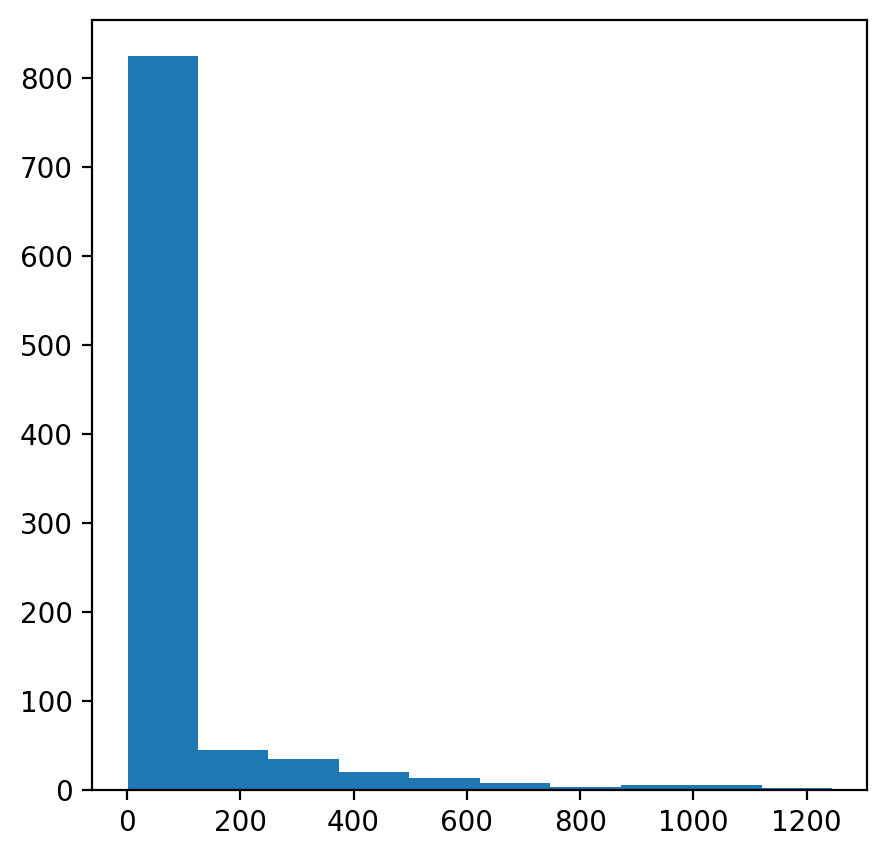

In [34]:
from collections import Counter

#computing frequency of each note
freq = dict(Counter(notes_))

#library for visualiation
import matplotlib.pyplot as plt

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

In [35]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

172


In [39]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
len(new_music)

12

In [40]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [41]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [42]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [43]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [44]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

In [45]:
def lstm():
  model = Sequential()
  model.add(LSTM(128,return_sequences=True))
  model.add(LSTM(128))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dense(n_vocab))
  model.add(Activation('softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
  return model

In [46]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           17200     
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            19264     
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0         
                                                        

In [47]:
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [49]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1)

Epoch 1/50
354/354 [==============================] - 8s 24ms/step - loss: 4.1907 - val_loss: 4.3124
Epoch 2/50
354/354 [==============================] - 9s 24ms/step - loss: 4.1344 - val_loss: 4.2684
Epoch 3/50
354/354 [==============================] - 9s 24ms/step - loss: 4.0857 - val_loss: 4.2339
Epoch 4/50
354/354 [==============================] - 9s 25ms/step - loss: 4.0433 - val_loss: 4.2027
Epoch 5/50
354/354 [==============================] - 9s 27ms/step - loss: 4.0065 - val_loss: 4.1766
Epoch 6/50
354/354 [==============================] - 9s 27ms/step - loss: 3.9706 - val_loss: 4.1864
Epoch 7/50
354/354 [==============================] - 9s 27ms/step - loss: 3.9394 - val_loss: 4.1503
Epoch 8/50
354/354 [==============================] - 9s 26ms/step - loss: 3.9071 - val_loss: 4.1476
Epoch 9/50
354/354 [==============================] - 11s 31ms/step - loss: 3.8800 - val_loss: 4.1419
Epoch 10/50
354/354 [==============================] - 11s 30ms/step - loss: 3.8502 - val_

In [ ]:
from keras.models import load_model
model = load_model('best_model.h5')

In [50]:
import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

1/1 [==============================] - 0s 19ms/step
[162, 162, 162, 162, 162, 162, 162, 162, 162, 162]


In [51]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [58]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = m21.note.Note(cn)
                new_note.storedInstrument = m21.instrument.Piano()
                notes.append(new_note)
                
            new_chord = m21.chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = m21.note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = m21.instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = m21.stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

In [59]:
convert_to_midi(predicted_notes)